In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.all import Simulator, StartMeshcat, LogVectorOutput

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    FixedOffsetFrame,
    JointIndex,
    Parser,
    PlanarJoint,
    RandomGenerator,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)

from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddShape, ycb
from manipulation.station import MakeHardwareStation, load_scenario
from pydrake.common import temp_directory

# sponana/src/sponana/utils.py
import sponana.utils
from sponana.controller import SpotController
from sponana.debug_logger import DebugLogger

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [4]:
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

add_spot = True
simulation_time = -1  # run indefinitely until ESC is pressed
# simulation_time = 1
table_height = 0.2
debug = True


def clutter_gen():
    scenario_data = f"""
cameras:
    table_top_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera0::base
            translation: [0, 0, {-0.05 + table_height}]
            rotation: !Rpy {{ deg: [-90, 0, 0] }}
    """
    if add_spot:
        # camera welded to the chest of Spot
        scenario_data += """
    spot_camera:
        name: spot_camera
        depth: True
        X_PB:
            translation: [0, 0.05, 0]
            base_frame: spot_camera::base
            rotation: !Rpy { deg: [-90, 0, 0] }
    """

    scenario_data += f"""       
directives:
- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: world
    child: camera0::base
    X_PC:
        translation: [0, 1.75, 1.0]
        rotation: !Rpy {{ deg: [-75, 0, 0] }}
    
- add_model:
    name: table_top
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top::table_top_center
    X_PC:
        translation: [0, 0, {table_height}]

- add_model:
    name: table_top2
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top2::table_top_center
    X_PC:
        translation: [0, 2.0, {table_height}]

- add_model:
    name: table_top3
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top3::table_top_center
    X_PC:
        translation: [0, -2.0, {table_height}]

# Walls
- add_model:
    name: table_top4
    file: package://sponana/table_top4.sdf
- add_weld:
    parent: world
    child: table_top4::table_top4_center

- add_model:
    name: table_top5
    file: package://sponana/table_top5.sdf
- add_weld:
    parent: world
    child: table_top5::table_top5_center

- add_model:
    name: table_top6
    file: package://sponana/table_top6.sdf
- add_weld:
    parent: world
    child: table_top6::table_top6_center

- add_model:
    name: table_top7
    file: package://sponana/table_top7.sdf
- add_weld:
    parent: world
    child: table_top7::table_top7_center

- add_model:
    name: floor
    file: package://sponana/platform.sdf
- add_weld:
    parent: world
    child: floor::platform_center

- add_model:
    name: back_wall
    file: package://sponana/table_top9.sdf
- add_weld:
    parent: world
    child: back_wall::table_top9_center
    """

    for i in range(22 if running_as_notebook else 2):
        object_num = rng.integers(0, len(ycb))
        scenario_data += f"""
- add_model:
    name: thing{i}
    file: package://manipulation/hydro/{ycb[object_num]} 
"""
    scenario_data += f"""
- add_model:
    name: banana
    file: package://sponana/banana/banana.sdf
    default_free_body_pose:
        banana: 
            translation: [0, 0, 1]
            rotation: !Rpy {{ deg: [0, 0, 0] }}    
"""

    if add_spot:
        scenario_data += """
- add_model:
    name: spot
    file: package://manipulation/spot/spot_with_arm_and_floating_base_actuators.urdf
    default_joint_positions:
        # fold the arm
        arm_sh1: [-3.1]
        arm_el0: [3.1]
        # initial position
        base_x: [1.0]
        base_rz: [3.14]

- add_model:
    name: spot_camera
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: spot::body
    child: spot_camera::base
    X_PC:
        translation: [0.4, 0, 0]
        # pointed slightly downward (by 30 degrees)
        rotation: !Rpy { deg: [-30, 0, -90] }

model_drivers:
    spot: !InverseDynamicsDriver {}
"""

    builder = DiagramBuilder()
    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(
        MakeHardwareStation(
            scenario, meshcat, parser_preload_callback=sponana.utils.configure_parser
        )
    )

    if add_spot:
        spot_plant = station.GetSubsystemByName(
            "spot.controller"
        ).get_multibody_plant_for_control()
        spot_controller = builder.AddSystem(SpotController(spot_plant, meshcat=meshcat))
        builder.Connect(
            spot_controller.get_output_port(),
            station.GetInputPort("spot.desired_state"),
        )

        if debug:
            # Connect debugger
            spot_camera = station.GetSubsystemByName("rgbd_sensor_camera0")
            debugger = builder.AddNamedSystem(
                "debug_logger", DebugLogger(spot_camera, meshcat)
            )
            builder.Connect(
                station.GetOutputPort("spot_camera.rgb_image"),
                debugger.get_color_image_input_port(),
            )
            builder.Connect(
                station.GetOutputPort("spot_camera.depth_image"),
                debugger.get_depth_image_input_port(),
            )
            LogVectorOutput(debugger.get_output_port(), builder)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant = station.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    z = 0.2 + table_height
    print("plant Floating Base", set(list(plant.GetFloatingBaseBodies())[0:3]))
    print(type(plant.GetFloatingBaseBodies()))
    floating_base_bodies_list = list(plant.GetFloatingBaseBodies())
    len_bodies = len(floating_base_bodies_list)

    center_table_bodies = set(floating_base_bodies_list[0 : len_bodies // 3])
    for body_index in center_table_bodies:
        tf = RigidTransform(
            UniformlyRandomRotationMatrix(generator),
            [rng.uniform(-0.20, 0.20), rng.uniform(-0.30, 0.30), z],
        )
        plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
        z += 0.01

    right_table_bodies = set(
        floating_base_bodies_list[len_bodies // 3 : len_bodies // 3 * 2]
    )
    for body_index in right_table_bodies:
        tf = RigidTransform(
            UniformlyRandomRotationMatrix(generator),
            [rng.uniform(-0.20, 0.20), 2 + rng.uniform(-0.30, 0.30), z],
        )
        plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
        z += 0.01

    left_table_bodies = set(floating_base_bodies_list[len_bodies // 3 * 2 :])
    for body_index in left_table_bodies:
        tf = RigidTransform(
            UniformlyRandomRotationMatrix(generator),
            [rng.uniform(-0.20, 0.20), -2 + rng.uniform(-0.30, 0.30), z],
        )
        plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
        z += 0.01

    sponana.utils.run_simulation(simulator, meshcat, finish_time=simulation_time)
    return simulator, diagram


simulator, diagram = clutter_gen()

Press Space to log system info
plant Floating Base {BodyIndex(25), BodyIndex(16), BodyIndex(24)}
<class 'set'>
Press Escape to stop the simulation


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



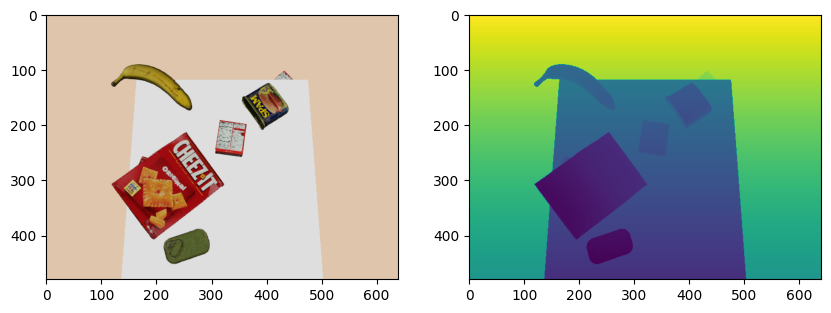

In [ ]:
# Check the camera on table top
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera0.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d6be65c-ca3c-46d4-a8f3-21f3622a2ace' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

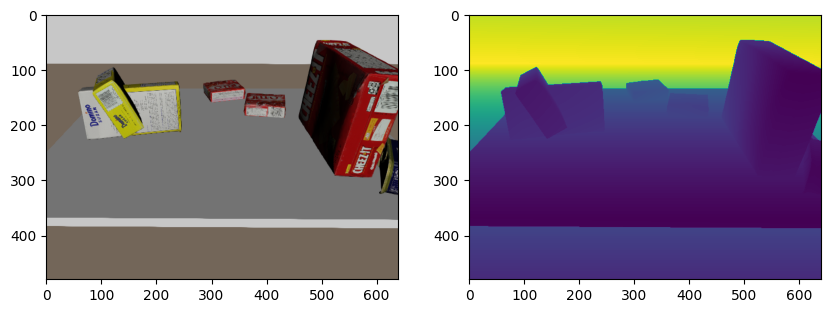

In [ ]:
# Check the camera on Spot
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("camera1.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera1.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

In [ ]:
# camera intrinsics
camera1 = station.GetSubsystemByName("rgbd_sensor_camera1")
camera_info = camera1.depth_camera_info()
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

intrinsics [[579.41125497   0.         319.5       ]
 [  0.         579.41125497 239.5       ]
 [  0.           0.           1.        ]]
focal length 579.4112549695427 579.4112549695427
field of view 1.009191289973297 0.7853981633974485


In [ ]:
# camera pose (X_PC)
context = simulator.get_mutable_context()
context = camera1.GetMyContextFromRoot(context)
camera1.GetOutputPort("body_pose_in_world").Eval(context)

RigidTransform(
  R=RotationMatrix([
    [-0.008421506104747128, 0.49998226924435213, -0.8659946932148002],
    [0.9999645384887045, 0.004210753052373562, -0.007293238224836748],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[0.5567144500883363, -0.0037332741934663566, 0.495],
)

In [ ]:
# Read out the table position from the hardware station

plant = station.GetSubsystemByName("plant")
pcontext = plant.GetMyContextFromRoot(context)
idx = plant.GetBodyByName("table_top_link", plant.GetModelInstanceByName("table_top")).index() # Get this
# get output port with body_poses
# then index into it by index -- see get_body_poses_output_port() docs!!
plant.get_body_poses_output_port().Eval(pcontext)[idx]

In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)